# Classifying flight bahavior of Lesser Kestrel using supervised learning

This notebook provides the executable code for analyzing the behavior of migrant birds (Lesser Kestrel). This is an supervised classification approach that attempts to predict the tartget categories (resting/flying/migrating) based on various features. All data were obtained from the Movebank database [Lesser Kestrel Data](https://www.movebank.org/cms/webapp?gwt_fragment=page=studies,path=study2398637362)

## Data preparation and Preprocessing

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_excel('data/tracking_falco.xlsx') # csv file had data loss, so i hat to take the excel file
display(df.head())
display(df.describe())
display(df.info())


event-id  visible           timestamp  location-long  location-lat  \
0  24286400131     True 2022-11-17 22:03:07     -16.165253     14.123400   
1  24286400136     True 2022-11-17 23:02:37     -16.165515     14.123566   
2  24286400143     True 2022-11-18 00:02:37     -16.164986     14.123301   
3  24292532653     True 2022-11-18 13:03:07     -16.268512     14.113659   
4  24292532663     True 2022-11-18 14:02:34     -16.309795     14.059176   

   external-temperature  ground-speed  heading  height-above-msl  \
0                   0.0           0.0      0.0             35.53   
1                   0.0           0.8     87.7             34.12   
2                   0.0           0.1      0.0             36.39   
3                   0.0           0.0      0.0             44.88   
4                   0.0           0.1      0.0             32.16   

  import-marked-outlier  gls:light-level sensor-type  \
0                   NaN                0         gps   
1                   NaN                0         gps   
2                   NaN                0         gps   
3                   NaN                0         gps   
4                   NaN                0         gps   

  individual-taxon-canonical-name tag-local-identifier  \
0                  Falco naumanni           1300000381   
1                  Falco naumanni           1300000381   
2                  Falco naumanni           1300000381   
3                  Falco naumanni           1300000381   
4                  Falco naumanni           1300000381   

  individual-local-identifier  \
0                      BA8966   
1                      BA8966   
2                      BA8966   
3                      BA8966   
4                      BA8966   

                                          study-name  \
0  (EBD) Lesser Kestrel (Falco naumanni) Senegal,...   
1  (EBD) Lesser Kestrel (Falco naumanni) Senegal,...   
2  (EBD) Lesser Kestrel (Falco naumanni) Senegal,...   
3  (EBD) Lesser Kestrel (Falco naumanni) Senegal,...   
4  (EBD) Lesser Kestrel (Falco naumanni) Senegal,...   

   MODIS Land Vegetation Indices .05deg Monthly Terra NDVI  \
0                                                NaN         
1                                                NaN         
2                                                NaN         
3                                                NaN         
4                                                NaN         

   Landcover_Classification  
0                       200  
1                       110  
2                       200  
3                        14  
4                        14

event-id                      timestamp  location-long  \
count  3.807950e+05                         380795  380795.000000   
mean   3.088353e+10  2023-10-18 02:45:24.197702656      -8.535959   
min    2.425255e+10            2022-11-13 20:56:31    -105.366022   
25%    2.638465e+10            2023-04-03 13:52:05     -15.665043   
50%    2.764265e+10            2023-06-06 03:05:17      -6.634431   
75%    3.784409e+10            2024-07-05 03:00:31      -4.426859   
max    4.161315e+10            2025-07-24 16:43:57       3.482862   
std    5.671088e+09                            NaN       5.300719   

        location-lat  external-temperature   ground-speed        heading  \
count  380795.000000         380795.000000  380795.000000  380795.000000   
mean       28.834398             11.350341       4.701478     152.220165   
min       -34.757181              0.000000       0.000000       0.000000   
25%        14.442790              0.000000       0.300000      39.600000   
50%        33.816627              0.000000       3.400000     143.200000   
75%        38.151438             31.900000       8.300000     257.000000   
max        52.823146             73.500000      77.400000     360.000000   
std        10.776794             16.927233       4.766115     117.018856   

       height-above-msl  gls:light-level  \
count     380795.000000    380795.000000   
mean         639.463871       213.364262   
min        -1989.560000         0.000000   
25%          141.350000         0.000000   
50%          479.280000         0.000000   
75%         1005.410000        90.000000   
max         9928.660000      2414.000000   
std          594.128817       427.965946   

       MODIS Land Vegetation Indices .05deg Monthly Terra NDVI  \
count                                       35393.000000         
mean                                            0.261839         
min                                             0.106760         
25%                                             0.187218         
50%                                             0.279348         
75%                                             0.313015         
max                                             0.434554         
std                                             0.070158         

       Landcover_Classification  
count             380795.000000  
mean                  56.952276  
min                   11.000000  
25%                   14.000000  
50%                   20.000000  
75%                  110.000000  
max                  210.000000  
std                   64.902871

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380795 entries, 0 to 380794
Data columns (total 18 columns):
 #   Column                                                   Non-Null Count   Dtype         
---  ------                                                   --------------   -----         
 0   event-id                                                 380795 non-null  int64         
 1   visible                                                  380795 non-null  bool          
 2   timestamp                                                380795 non-null  datetime64[ns]
 3   location-long                                            380795 non-null  float64       
 4   location-lat                                             380795 non-null  float64       
 5   external-temperature                                     380795 non-null  float64       
 6   ground-speed                                             380795 non-null  float64       
 7   heading                               

None

* Ground-speed with 77 kmh and height above msl with -1989.56000 are indicators for strong outliers and will be processed.
* External temperature and NDVI have unfortunately too many NaN and connot be considered in further analysis.

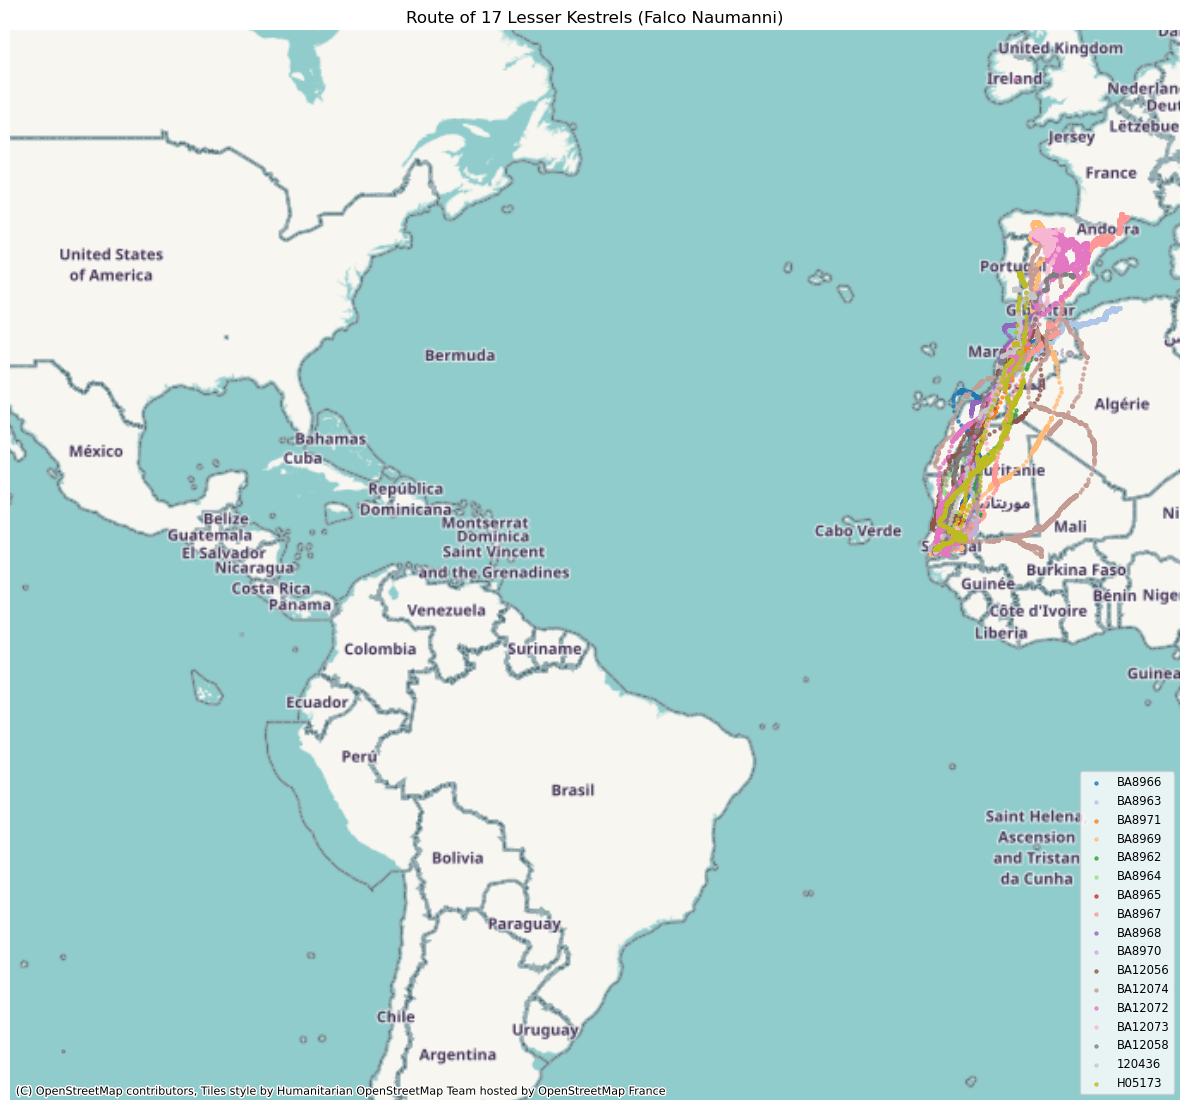

In [3]:
import contextily as cx

# Convert the DataFrame to a GeoDataFrame for better spatial handling and combination with basemap
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['location-long'], df['location-lat']),
    crs='EPSG:4326'
)
gdf_webmerc = gdf.to_crs(epsg=3857)

# Plot routes for each of the 17 birds with a different color
bird_ids = gdf_webmerc['individual-local-identifier'].unique()
cmap = plt.colormaps['tab20'] 
colors = [cmap(i % 20) for i in range(len(bird_ids))] 

fig, ax = plt.subplots(figsize=(12, 12))
for i, bird_id in enumerate(bird_ids):
    gdf_bird = gdf_webmerc[gdf_webmerc['individual-local-identifier'] == bird_id]
    gdf_bird.plot(ax=ax, color=colors[i], markersize=5, label=bird_id, alpha=0.7)

cx.add_basemap(ax)
ax.set_axis_off()
plt.title("Route of 17 Lesser Kestrels (Falco Naumanni)")
plt.legend(loc='lower right', fontsize='small')
plt.tight_layout()
plt.show()


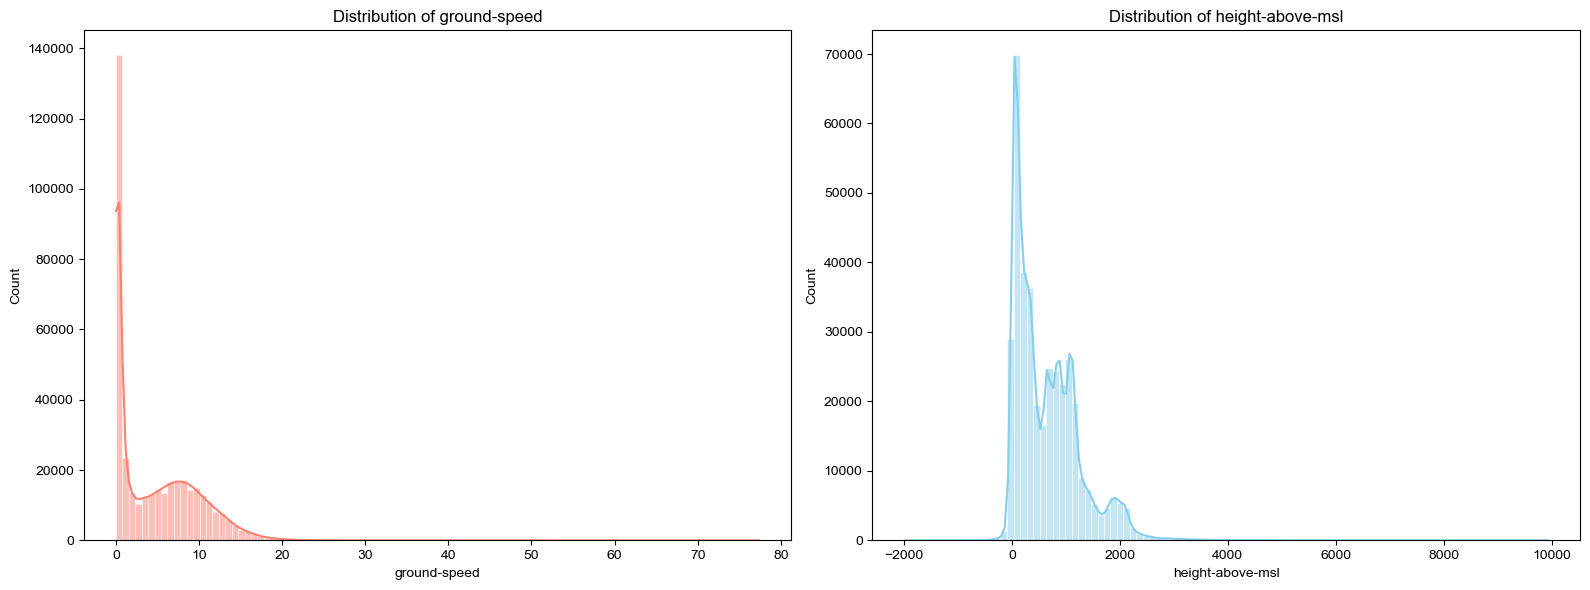

In [4]:
# Plot the distribution of ground-speed and height-above-msl
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
sns.set_style("whitegrid")

# Distribution of ground-speed
sns.histplot(df['ground-speed'], bins=100, kde=True, color='salmon', ax=axs[0])
axs[0].set_title('Distribution of ground-speed')
axs[0].set_xlabel('ground-speed')
axs[0].set_ylabel('Count')

# Distribution of height-above-msl
sns.histplot(df['height-above-msl'], bins=100, kde=True, color='skyblue', ax=axs[1])
axs[1].set_title('Distribution of height-above-msl')
axs[1].set_xlabel('height-above-msl')
axs[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

### Outlier detection and extraction

In [5]:
# outlier detection, because we see there are 2 main spatial outliers in the plot
west_outlier = df.loc[df['location-long'].idxmin()]
north_outlier = df.loc[df['location-lat'].idxmax()]

# IQR-based outlier detection for ground speed and height above mean sea level (MSL)
def get_outliers_iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 4 * iqr
    upper_bound = q3 + 4 * iqr
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

ground_speed_outliers = get_outliers_iqr(df, 'ground-speed')

height_outliers = get_outliers_iqr(df, 'height-above-msl')

# minus values in height-above-msl
height_outlier_min = df[df['height-above-msl'] < 0]

print("\n West outlier:")
print(west_outlier[['timestamp', 'location-lat', 'location-long', 'individual-local-identifier']])

print("\n North outlier:")
print(north_outlier[['timestamp', 'location-lat', 'location-long', 'individual-local-identifier']])

print("\n Highest speed):")
print(ground_speed_outliers[['timestamp', 'ground-speed', 'individual-local-identifier']])

print("\n Highest points:")
print(height_outliers[['timestamp', 'height-above-msl','ground-speed', 'individual-local-identifier']])

print("\n Negativ points:")
print(height_outlier_min[['timestamp', 'height-above-msl', 'individual-local-identifier']])


 West outlier:
timestamp                      2023-12-21 14:03:18
location-lat                            -34.757181
location-long                          -105.366022
individual-local-identifier                BA12058
Name: 347398, dtype: object

 North outlier:
timestamp                      2024-12-20 10:02:06
location-lat                             52.823146
location-long                            -7.941158
individual-local-identifier                BA12072
Name: 329297, dtype: object

 Highest speed):
                 timestamp  ground-speed individual-local-identifier
204734 2023-04-07 14:02:05          51.1                      BA8968
258659 2024-09-13 12:47:05          77.4                     BA12056

 Highest points:
                 timestamp  height-above-msl  ground-speed  \
15099  2023-04-23 09:42:43           4539.04           0.1   
15443  2023-04-23 22:02:49           6379.14           0.8   
15452  2023-04-24 07:02:36           5020.81           6.9   
24189  2023-

The map shows two clear spatial outliers that can be removed. The strong outliers in speed also seem too extreme and will be removed. Height above MSL has several outliers and almost 10,000 points in the negative range, which is illogical. I also tried incorporating the realistic height values into the later model, but since this didn't have a noticeable impact, i decided not to consider in the further analysis.

In [6]:
# Combination of indices to drop
indices_to_drop = [west_outlier.name, north_outlier.name] + list(ground_speed_outliers.index)

df = df.drop(indices_to_drop)

### Dataset cleaning and feature engineering

In [7]:
# filter relevant columns for the later model
df_filtered = df[['timestamp', 'individual-local-identifier', 'location-long', 'location-lat', 'ground-speed', 'heading', 'Landcover_Classification']].copy()

In [8]:
# adding datetime features
df_filtered["hour"] = df_filtered["timestamp"].dt.hour
df_filtered["day"] = df_filtered["timestamp"].dt.day
df_filtered["month"] = df_filtered["timestamp"].dt.month
df_filtered["year"] = df_filtered["timestamp"].dt.year

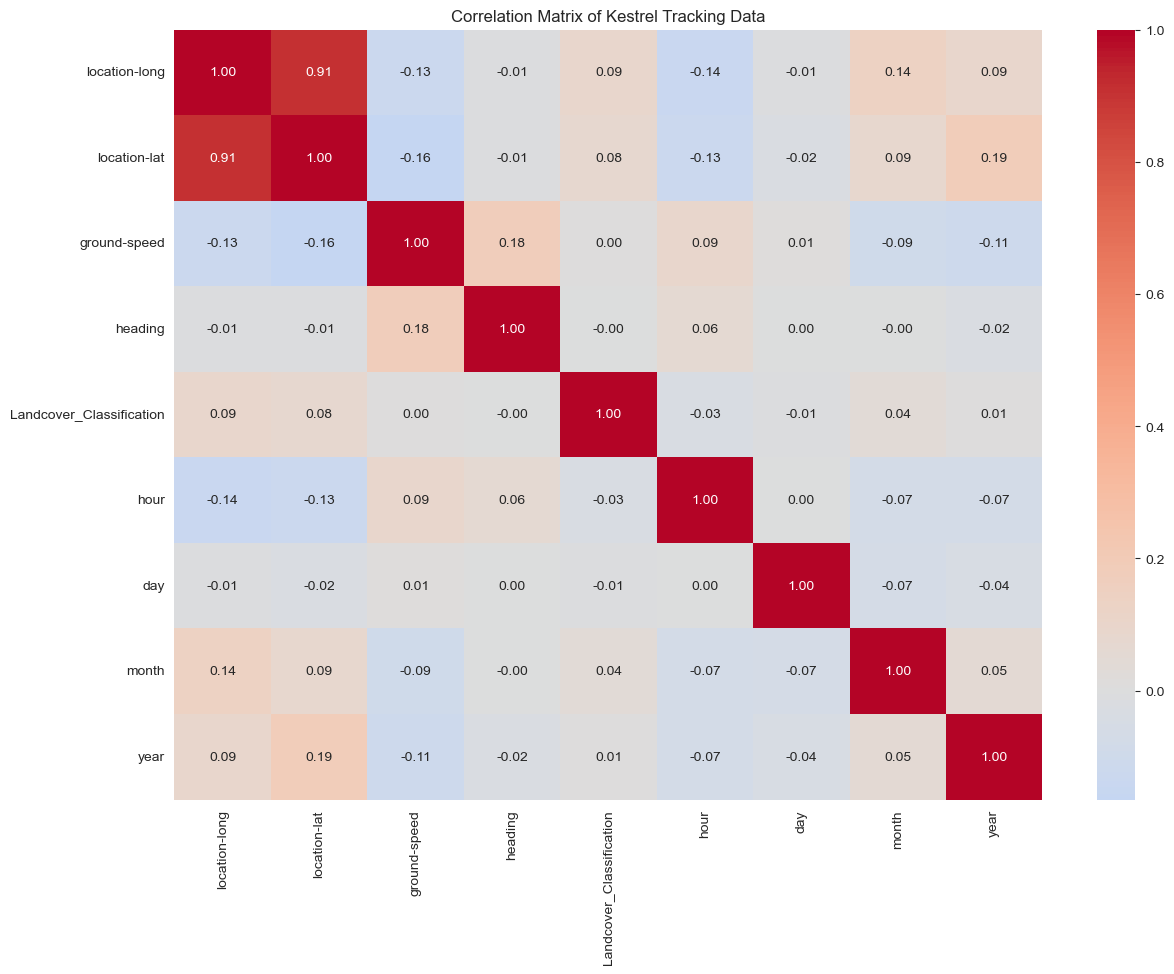

In [9]:
# display Correlation Matrix
corr = df_filtered.corr(numeric_only=True)
plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Kestrel Tracking Data")
plt.show()

There are no strong multicollinarities except for the locations. There are no strong multicollinarities except for the locations We already see that heading has the biggest impact on ground-speed with 0.18. Overall, the correlations to groundspeed are very low, which could be a sign that the model cannot perform well.

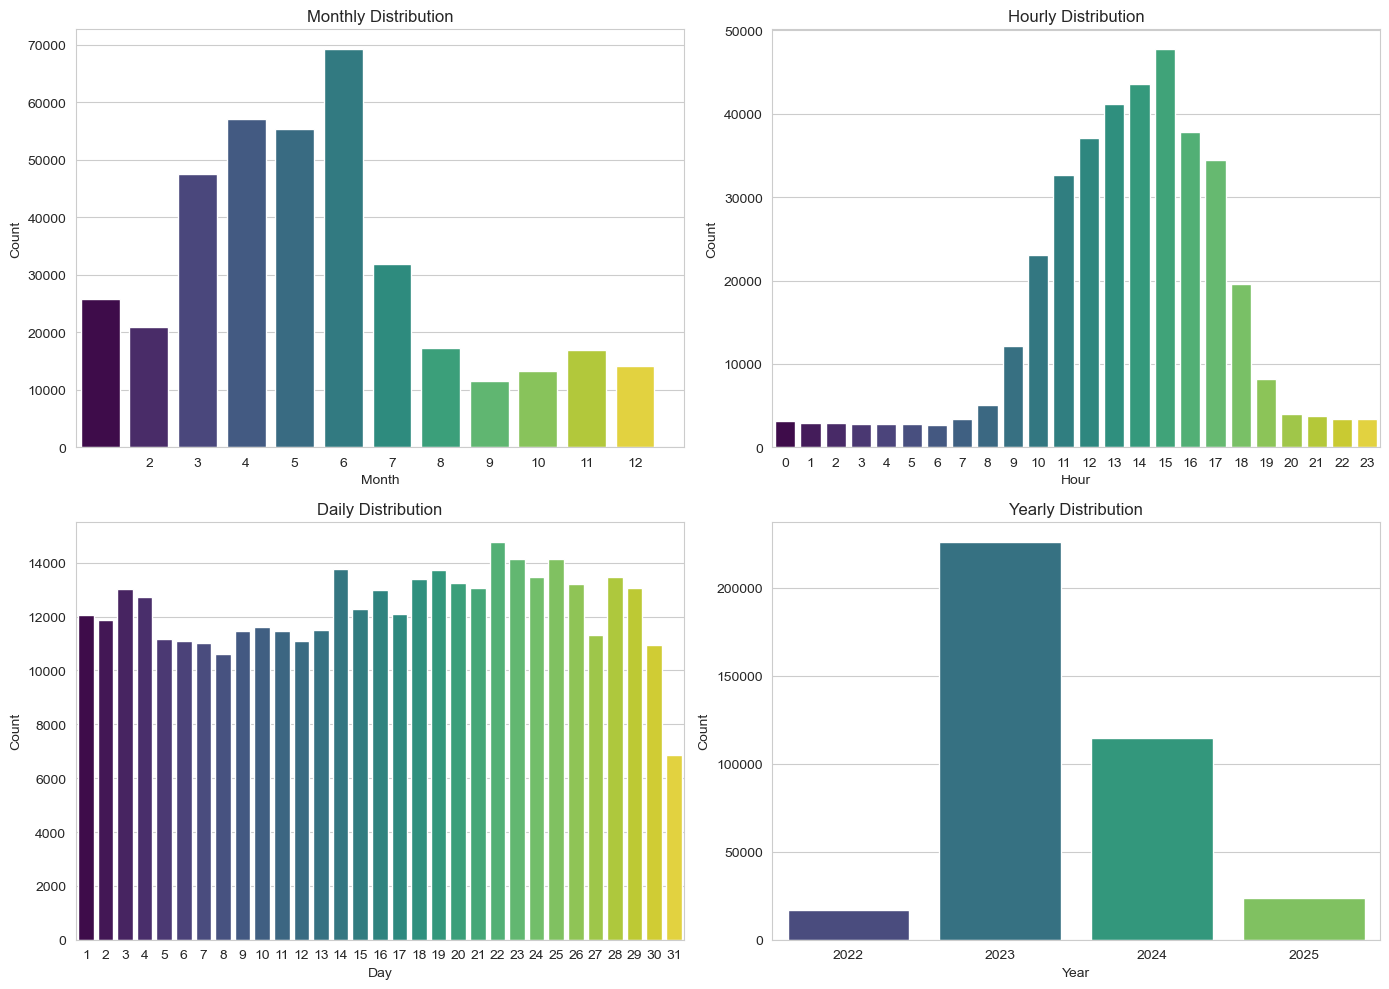

In [10]:
# Count temporal distributions
month_counts = df_filtered['month'].value_counts().sort_index()
hour_counts = df_filtered['hour'].value_counts().sort_index()
day_counts = df_filtered['day'].value_counts().sort_index()
year_counts = df_filtered['year'].value_counts().sort_index()

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
sns.set_style("whitegrid")

def plot_bar(ax, x_data, y_data, title, xlabel, ylabel, xticks=None):
    sns.barplot(
        x=x_data,
        y=y_data,
        hue=x_data,
        dodge=False,
        ax=ax,
        palette="viridis",
        legend=False
    )
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xticks is not None:
        ax.set_xticks(xticks)

# PMonth distribution
plot_bar(axs[0, 0], month_counts.index, month_counts.values,
         "Monthly Distribution", "Month", "Count", xticks=range(1, 13))

# Hour distribution
plot_bar(axs[0, 1], hour_counts.index, hour_counts.values,
         "Hourly Distribution", "Hour", "Count", xticks=range(0, 24))

# Day distribution
plot_bar(axs[1, 0], day_counts.index, day_counts.values,
         "Daily Distribution", "Day", "Count")

# Year distribution
plot_bar(axs[1, 1], year_counts.index.astype(str), year_counts.values,
         "Yearly Distribution", "Year", "Count")

plt.tight_layout()
plt.show()

Months, hours and years are very unbalanced in the dataset. This can be problematic when training labels, especially when learning overrepresented features. This is important to consider for later model training.

In [11]:
from sklearn.cluster import KMeans

coords = df_filtered[['location-lat', 'location-long']].copy()

# KMeans with 3 clusters (approximately Spain, Transit, Senegal)
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
df_filtered['geo_zone'] = kmeans.fit_predict(coords)


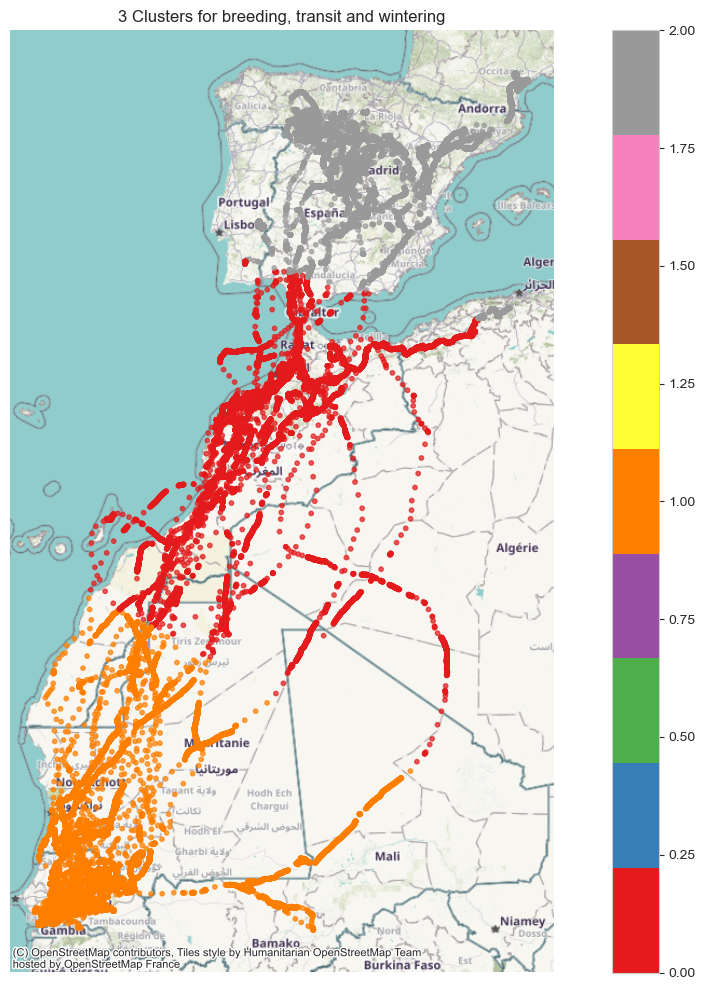

In [12]:
gdf = gpd.GeoDataFrame(
    df_filtered,
    geometry=gpd.points_from_xy(df_filtered['location-long'], df_filtered['location-lat']),
    crs='EPSG:4326'
)
gdf_webmerc = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 10))

# plotting the clusters with different colors
gdf_webmerc.plot(
    ax=ax,
    column='geo_zone',
    cmap='Set1',
    markersize=10,
    alpha=0.7,
    legend=True
)

cx.add_basemap(ax)
ax.set_axis_off()
plt.title('3 Clusters for breeding, transit and wintering')
plt.tight_layout()
plt.show()



Using the unsupervised clustering approach, an attempt was made to cluster the coordinates of migrant birds into three relevant geozones. Clustering for Spain worked relatively well, although it performed somewhat less well between the wintering grounds and the transit area. KMEANS is not normally intended for such clustering applications and is more commonly used for spherical clusters. However, it has the advantage that the desired number of clusters can be specified, and the calculation is quite fast. This rough division of geozones is not perfect, but it can be helpful and can be incorporated into the model.

## Model and Classification preparation

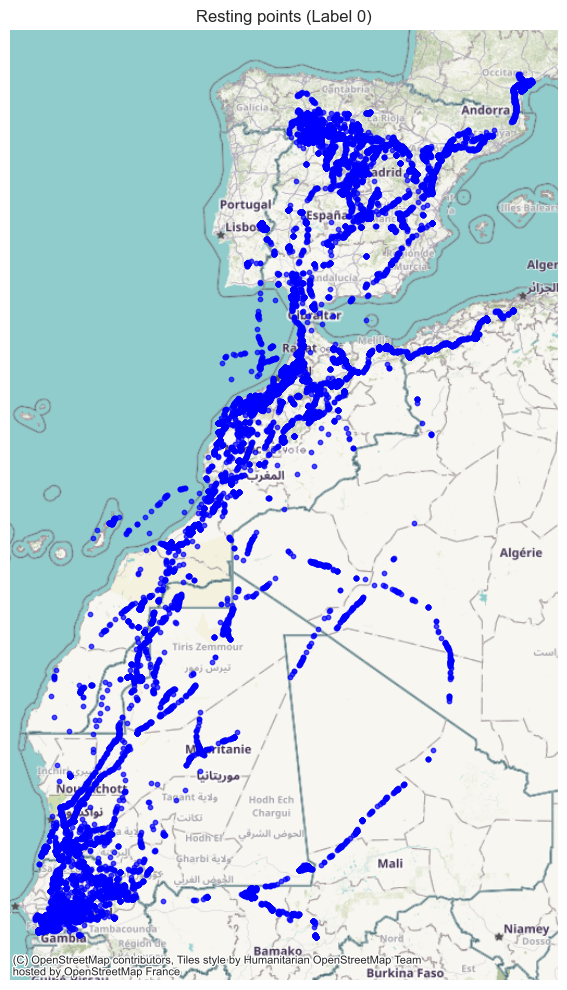

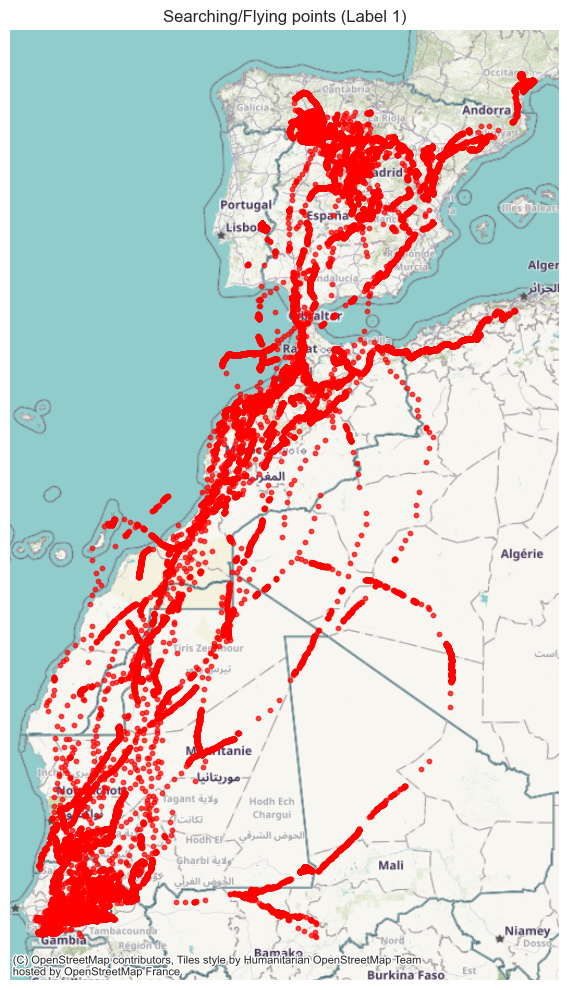

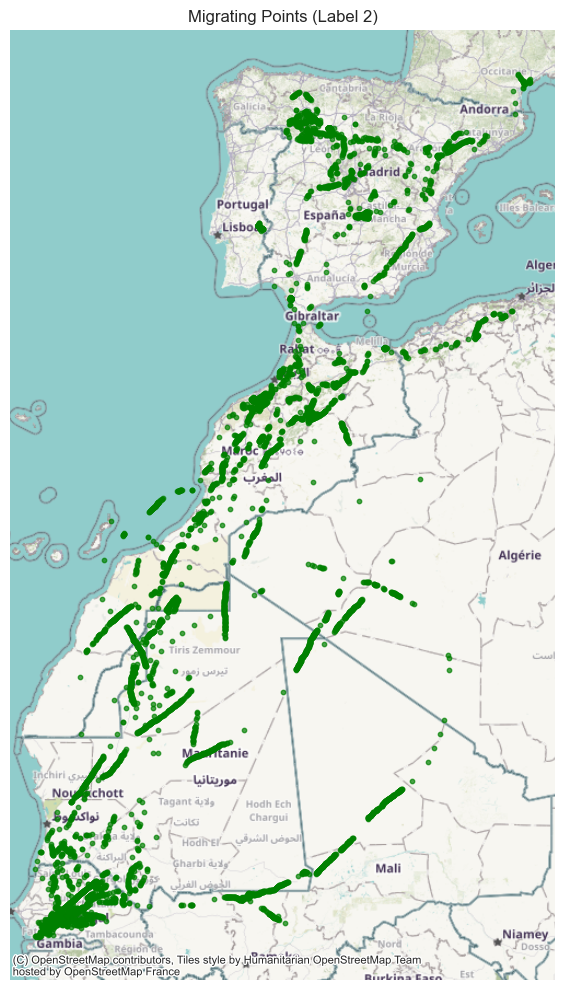

In [13]:
from shapely.geometry import Point

# classifaction of the behavior categories
def classify_behavior_simple(row):
    if row['ground-speed'] < 3:
        return 0  # resting
    elif 3 <= row['ground-speed'] < 15:
        return 1  # flying
    elif row['ground-speed'] >= 15: 
        return 2  # migrating


# apply label to datasets
df_filtered['label'] = df_filtered.apply(classify_behavior_simple, axis=1)
gdf_webmerc['label'] = gdf_webmerc.apply(classify_behavior_simple, axis=1)

# splitting different behavior categories
gdf_rast = gdf_webmerc[gdf_webmerc['label'] == 0]
gdf_searchflying = gdf_webmerc[gdf_webmerc['label'] == 1]
gdf_migrating = gdf_webmerc[gdf_webmerc['label'] == 2]

#  only resting points
fig, ax = plt.subplots(figsize=(10, 10))
gdf_rast.plot(
    ax=ax,
    color='blue',
    markersize=10,
    alpha=0.7
)
cx.add_basemap(ax)
ax.set_axis_off()
plt.title("Resting points (Label 0)")
plt.tight_layout()
plt.show()

# only searching/flying points
fig, ax = plt.subplots(figsize=(10, 10))
gdf_searchflying.plot(
    ax=ax,
    color='red',
    markersize=10,
    alpha=0.7
)
cx.add_basemap(ax)
ax.set_axis_off()
plt.title("Searching/Flying points (Label 1)")
plt.tight_layout()
plt.show()

# 4. only migrating points
fig, ax = plt.subplots(figsize=(10, 10))
gdf_migrating.plot(
    ax=ax,
    color='green',
    markersize=10,
    alpha=0.7
)
cx.add_basemap(ax)
ax.set_axis_off()
plt.title("Migrating Points (Label 2)")
plt.tight_layout()
plt.show()


A clear separation is not discernible. Every day, a bird has several values and these are not consistent in ground-speed. This makes model training more difficult.

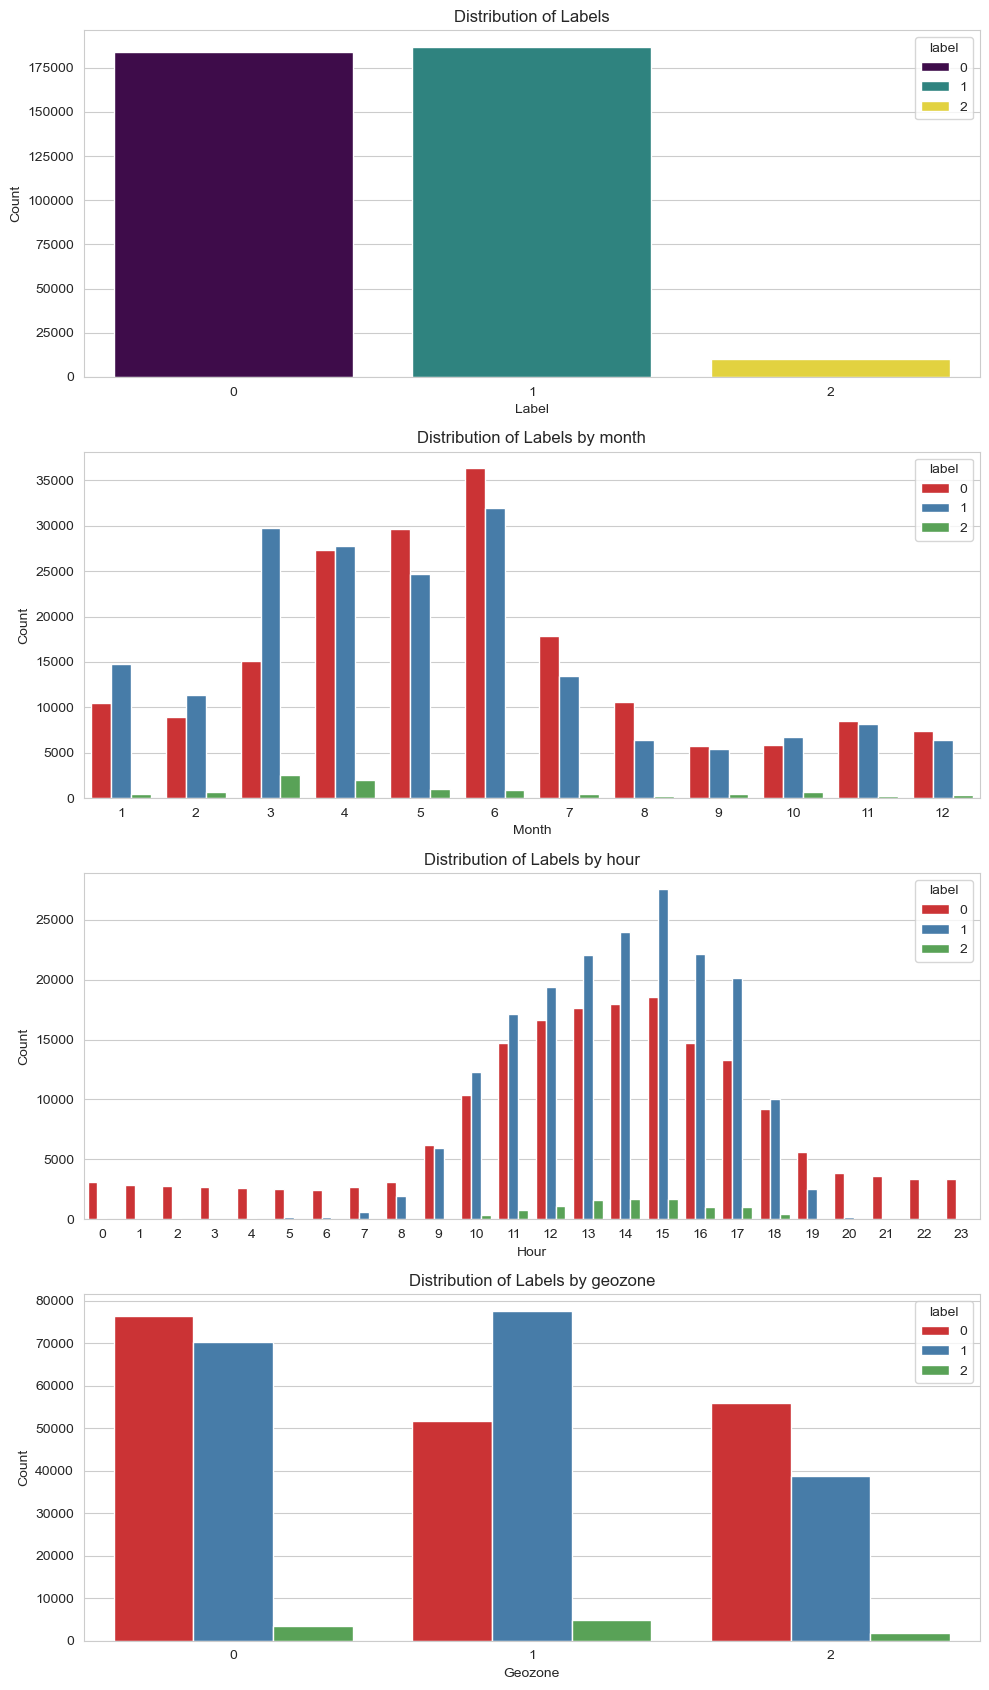

In [14]:
fig, axs = plt.subplots(4, figsize=(10, 17))

# Plot the distribution of labels 
sns.countplot(x='label', data=df_filtered, palette='viridis', hue='label', ax=axs[0])
axs[0].set_title('Distribution of Labels')
axs[0].set_xlabel('Label')
axs[0].set_ylabel('Count')

# Plot the distribution of labels dependant on the month 
sns.countplot(data=df_filtered, x='month', hue='label', palette='Set1', ax=axs[1])
axs[1].set_title('Distribution of Labels by month')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Count')

# Plot the distribution of labels dependant on the hour 
sns.countplot(data=df_filtered, x='hour', hue='label', palette='Set1', ax=axs[2])
axs[2].set_title('Distribution of Labels by hour')
axs[2].set_xlabel('Hour')
axs[2].set_ylabel('Count')

# plot the distribution of labels dependant on the geozone
sns.countplot(data=df_filtered, x='geo_zone', hue='label', palette='Set1', ax=axs[3])
axs[3].set_title('Distribution of Labels by geozone')
axs[3].set_xlabel('Geozone')
axs[3].set_ylabel('Count')

fig.tight_layout()
plt.show()

Label 2 is very underrepresented. Labels 0 and 1 are roughly balanced in the monthly distribution. In the hourly distribution, label 0 (resting) is logically most pronounced during the night hours. As expected, resting is more prevalent in the breeding and wintering area than in transit

Because the dataset is already very large and model training would take too long, we perform a reduction. This ensures that the labels are approximately equally represented in the new, smaller dataset. This allows the three classes to be trained more evenly, which should improve model performance.


In [15]:
from sklearn.utils import resample

# Reduction to only 10% of original dataset
# A lot of data is lost, but this way the label balance can be secured and there are still enough data points
target_frac = 0.1
target_size = int(len(df_filtered) * target_frac)

# group by label
grouped = df_filtered.groupby('label')

# same number of samples for each label
n_classes = grouped.ngroups
samples_per_class = max(1, target_size // n_classes)
df_balanced_sample = grouped.apply(lambda x: x.sample(n=min(len(x), samples_per_class), random_state=42))
df_balanced_sample = df_balanced_sample.reset_index(drop=True)

# sort by time
df_sorted = df_balanced_sample.sort_values('timestamp').reset_index(drop=True)

C:\Users\Nutzer\AppData\Local\Temp\ipykernel_18720\2922134348.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced_sample = grouped.apply(lambda x: x.sample(n=min(len(x), samples_per_class), random_state=42))


In [16]:
df_sorted.head()

timestamp individual-local-identifier  location-long  \
0 2022-11-14 03:04:55                      BA8963     -16.166949   
1 2022-11-14 06:55:55                      BA8962     -16.166339   
2 2022-11-14 11:44:58                      BA8963     -16.020048   
3 2022-11-14 12:05:57                      BA8963     -15.960736   
4 2022-11-14 12:55:49                      BA8962     -16.166426   

   location-lat  ground-speed  heading  Landcover_Classification  hour  day  \
0     14.123696           0.5    263.7                        20     3   14   
1     14.123453           0.1     59.9                       110     6   14   
2     14.037162          13.4    105.3                        14    11   14   
3     14.031680           1.6    320.2                        14    12   14   
4     14.123434           0.2      0.0                       110    12   14   

   month  year  geo_zone  label  
0     11  2022         1      0  
1     11  2022         1      0  
2     11  2022         1      1  
3     11  2022         1      0  
4     11  2022         1      0

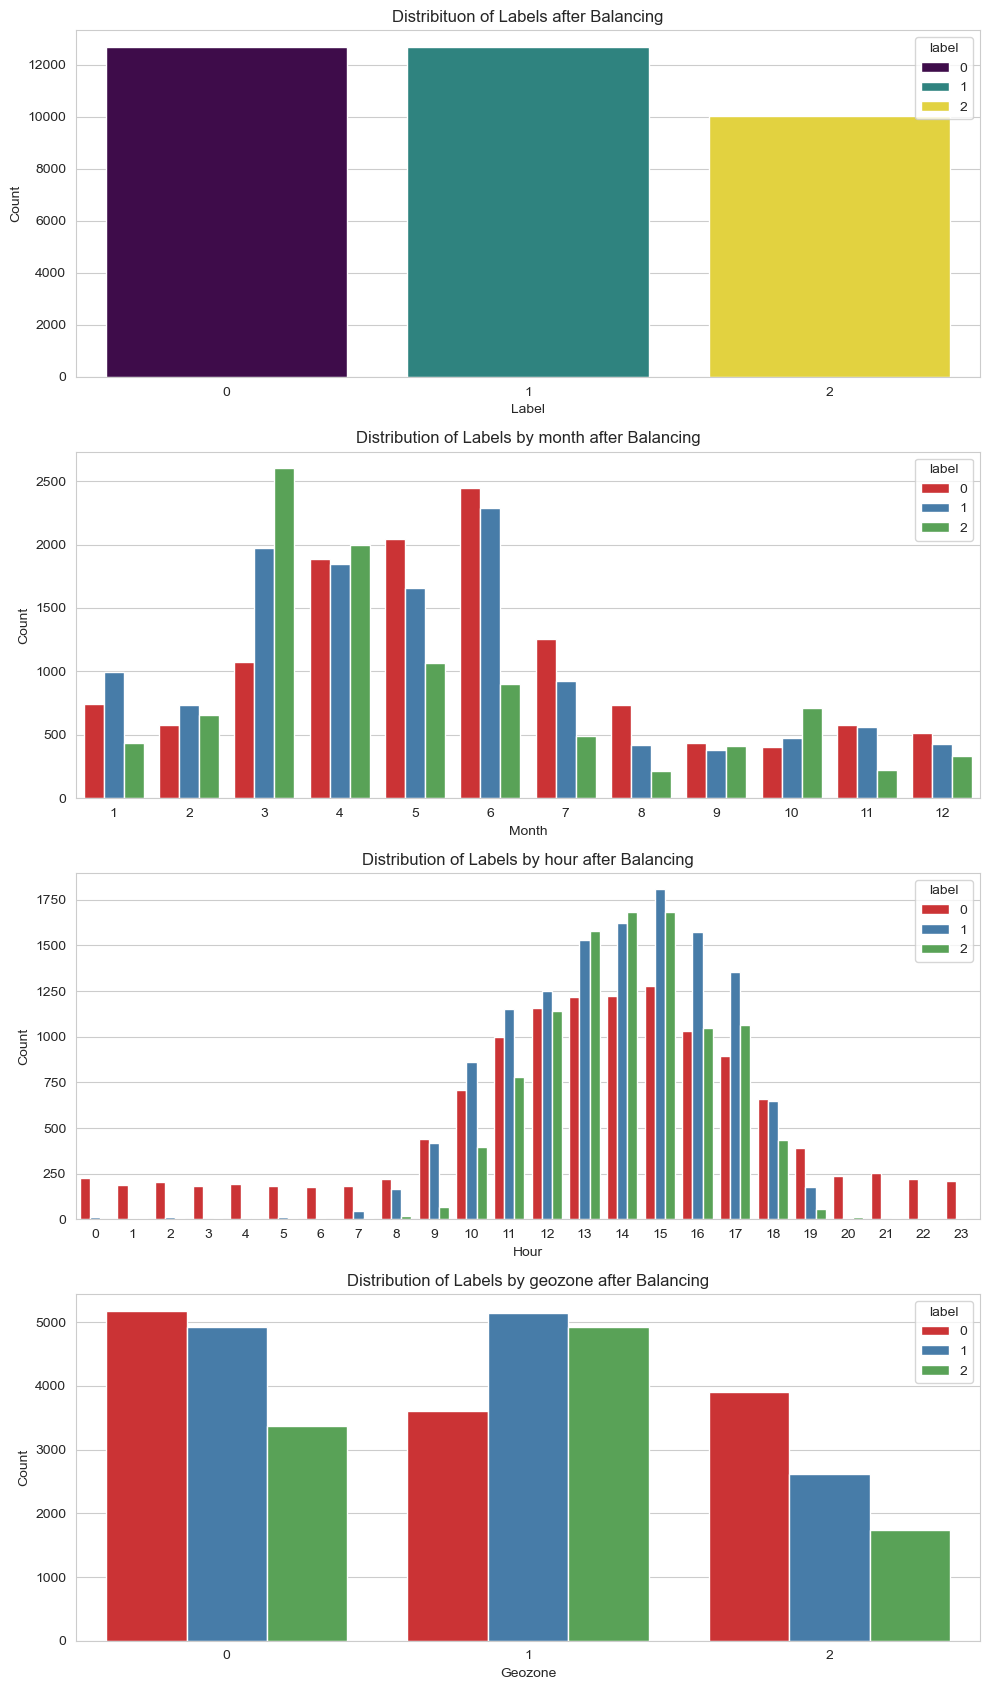

In [17]:
fig, axs = plt.subplots(4, figsize=(10, 17))

# Plot the distribution of labels 
sns.countplot(x='label', data=df_sorted, hue='label', palette='viridis', ax=axs[0])
axs[0].set_title('Distribituon of Labels after Balancing')
axs[0].set_xlabel('Label')
axs[0].set_ylabel('Count')

# Plot the distribution of months 
sns.countplot(data=df_sorted, x='month', hue='label', palette='Set1', ax=axs[1])
axs[1].set_title('Distribution of Labels by month after Balancing')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Count')

# Plot the distribution of hours 
sns.countplot(data=df_sorted, x='hour', hue='label', palette='Set1', ax=axs[2])
axs[2].set_title('Distribution of Labels by hour after Balancing')
axs[2].set_xlabel('Hour')
axs[2].set_ylabel('Count')

# plot the distribution of labels dependant on the geozone
sns.countplot(data=df_sorted, x='geo_zone', hue='label', palette='Set1', ax=axs[3])
axs[3].set_title('Distribution of Labels by geozone after Balancing')
axs[3].set_xlabel('Geozone')
axs[3].set_ylabel('Count')

fig.tight_layout()
plt.show()

Label 2 is still underrepresented, but now it is much more balanced overall.

In [18]:
# Timesplitting with 80% for training and 20% for testing, which is a common approach
# Usage of timesplitting, because we want to predict fututre flying behavior and with this way we avoid data leakage
split_index = int(0.8 * len(df_sorted))
split_timestamp = df_sorted.loc[split_index, 'timestamp']

train_df = df_sorted[df_sorted['timestamp'] <= split_timestamp]
test_df = df_sorted[df_sorted['timestamp'] > split_timestamp]

print(f"Timesplitt at: {split_timestamp}")
print(f"Traindata: {len(train_df)} rows, Testdata: {len(test_df)} rows")
# print period of the data
print(f"Range of Traindata: {train_df['timestamp'].min()} to {train_df['timestamp'].max()}")
print(f"Range of Testdata: {test_df['timestamp'].min()} to {test_df['timestamp'].max()}")

Timesplitt at: 2024-08-02 17:44:11
Traindata: 28345 rows, Testdata: 7085 rows
Range of Traindata: 2022-11-14 03:04:55 to 2024-08-02 17:44:11
Range of Testdata: 2024-08-02 17:46:06 to 2025-07-24 15:44:31


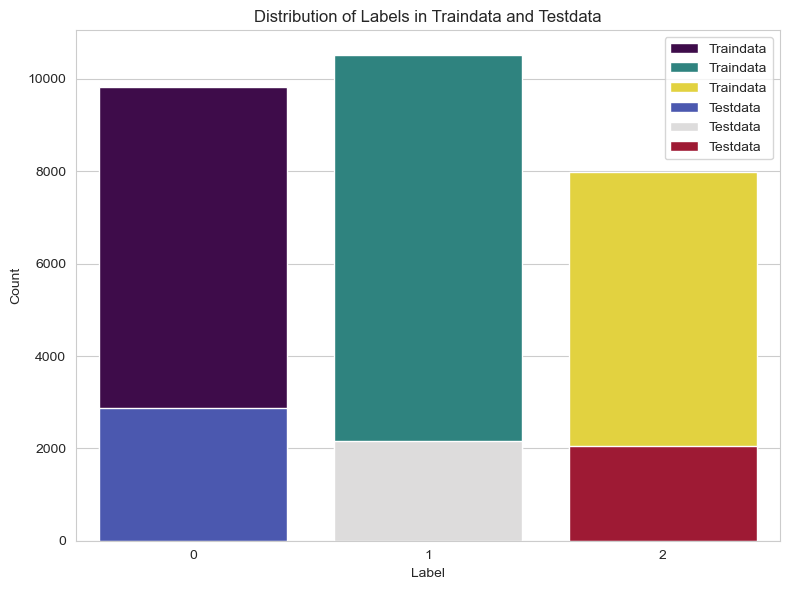

In [19]:
# plot distribution of labels in training and test set
plt.figure(figsize=(8, 6))
sns.countplot(x='label', hue='label', data=train_df, palette='viridis', label='Traindata', legend=False)
sns.countplot(x='label', hue='label', data=test_df, palette='coolwarm', label='Testdata', legend=False)
plt.title('Distribution of Labels in Traindata and Testdata')
plt.xlabel('Label')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()

## Model Training and Evaluation


🔍 Model: RandomForest
Best Parameters: {'model__n_estimators': 150, 'model__min_samples_split': 2, 'model__max_depth': 10}
              precision    recall  f1-score   support

           0       0.72      0.60      0.65      2869
           1       0.43      0.46      0.44      2167
           2       0.57      0.67      0.61      2049

    accuracy                           0.57      7085
   macro avg       0.57      0.57      0.57      7085
weighted avg       0.59      0.57      0.58      7085



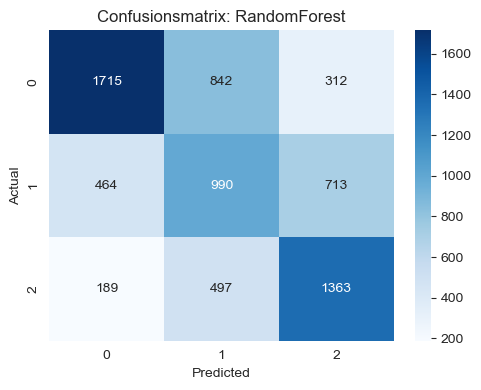


🔍 Model: XGBoost
Best Parameters: {'model__n_estimators': 50, 'model__max_depth': 3, 'model__learning_rate': 0.2, 'model__colsample_bytree': 0.33}
              precision    recall  f1-score   support

           0       0.85      0.49      0.62      2869
           1       0.42      0.62      0.50      2167
           2       0.58      0.64      0.61      2049

    accuracy                           0.57      7085
   macro avg       0.62      0.58      0.58      7085
weighted avg       0.64      0.57      0.58      7085



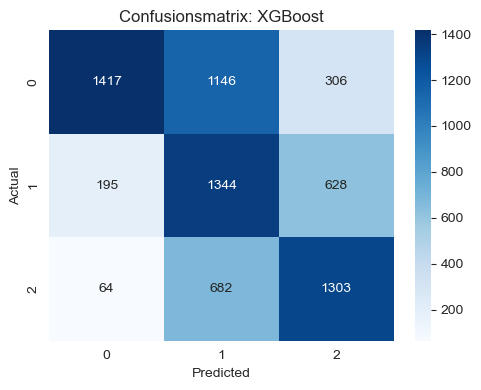


🔍 Model: LogisticRegression
Best Parameters: {'model__max_iter': 500, 'model__C': 0.1}
              precision    recall  f1-score   support

           0       0.64      0.62      0.63      2869
           1       0.37      0.49      0.42      2167
           2       0.46      0.32      0.38      2049

    accuracy                           0.49      7085
   macro avg       0.49      0.48      0.48      7085
weighted avg       0.51      0.49      0.49      7085



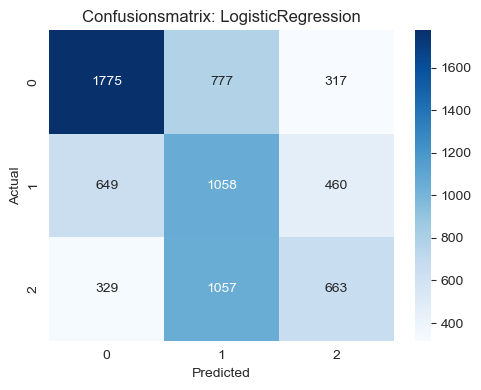


 Comparasion of f1 macro scores:
RandomForest: 0.570
XGBoost: 0.578
LogisticRegression: 0.477


In [20]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import ParameterSampler

# 5. Features & Label
feature_cols = ['heading', 'location-long', 'location-lat', 'month', 'day', 'hour','Landcover_Classification', 'geo_zone']
X_train = train_df[feature_cols]
y_train = train_df['label']
X_test = test_df[feature_cols]
y_test = test_df['label']

# splitting feature data into categorical and numerical for models
categorical = ['month', 'day', 'hour', 'Landcover_Classification', 'geo_zone']
numerical = ['heading', 'location-long', 'location-lat']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical), # relevant for logisiticregression
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical) # relevant for XGBoost and RandomForest
    ]
)

# define models
models = {
    "RandomForest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, n_jobs=-1),
    "LogisticRegression": LogisticRegression(random_state=42, n_jobs=-1) # multinomial is standard
}


# 9. define only most important hyperparamters
param_grids = {
    "RandomForest": {
        'model__n_estimators': [50, 100, 150],
        'model__max_depth': [5, 10, None],
        'model__min_samples_split': [2, 5, 10]
    },
    "XGBoost": {
        'model__n_estimators': [50, 100, 150],
        'model__max_depth': [3, 5, 10],
        'model__learning_rate': [0.05, 0.1, 0.2],
        'model__colsample_bytree': [0.33, 0.66, 1.0]
    },
      "LogisticRegression": {
        'model__C': [0.1, 1.0, 10, 20],
        'model__max_iter': [500, 750, 1000],
    }
    }


# deine Pipeline with Tuning and Evaluation
results = {}

for name, model in models.items():
    print(f"\n🔍 Model: {name}")
    
    pipe = Pipeline([
        ('pre', preprocessor),
        ('model', model)
    ])
    
    # ParameterSampler
    # no cv, because dataset hat still a lot of datapoints and therefore we can do more iterations with shorter runtime
    param_sampler = list(ParameterSampler(
        param_grids[name],
        n_iter=10,
        random_state=42
    ))

    best_score = -1
    best_model = None
    best_params = None
    y_pred_best = None

    # Hyperparameter loop
    for params in param_sampler:
        pipe.set_params(**params)
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        score = f1_score(y_test, y_pred, average='macro')

        if score > best_score:
            best_score = score
            best_model = pipe
            best_params = params
            y_pred_best = y_pred

    # Best Model-Evaluation
    print("Best Parameters:", best_params)
    print(classification_report(y_test, y_pred_best))

    # Confusionsmatrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusionsmatrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    results[name] = {
        "model": best_model,
        "score": best_score,
        "params": best_params
    }

# Score-Comparison for further analysis steps 
print("\n Comparasion of f1 macro scores:")
for name, res in results.items():
    print(f"{name}: {res['score']:.3f}")


As expected, Random Forest and xGBoost perform better than logistic regression because the relationships between the variables are not clearly linear. XGBoost performs best with an F1 score of 0.578, but not significantly different from Random Forest's 0.570. Overall, the models' performance isn't that good because the feature data doesn't have a strong impact on speed. 

It would require either better features or a dataset that isn't too complex, with better classification and spatial separation of the flying behavior. I thought that the speed could be better spatially separated for migrant birds, but this simplified classification is too simple in such a large dataset.

On average, the three models performed best in predicting resting. XGBoosting achieved a precision value of 0.85, which is very good. However, it achieved a significantly worse recall of 0.49. This better prediction compared to flying and migrating could be due to the correlation between nighttime hours, geozones and resting (see figure "Distribution of labels by hour" and "Distribution of Labels by Geozones").

### Feature Importance measures

In [21]:

from sklearn.inspection import permutation_importance

# Permutation Importance
best_model = results["XGBoost"]["model"]  # XGboost best model

fi_mean = permutation_importance(
        best_model,
        X_test,
        y_test,
        random_state=42
    ).importances_mean  # get avg. importance score for each feature


df_feature_importances = pd.DataFrame(
    {"XGBoost":fi_mean.tolist()},
    index = X_test.columns.to_list(),
)

<Figure size 1500x2500 with 0 Axes>

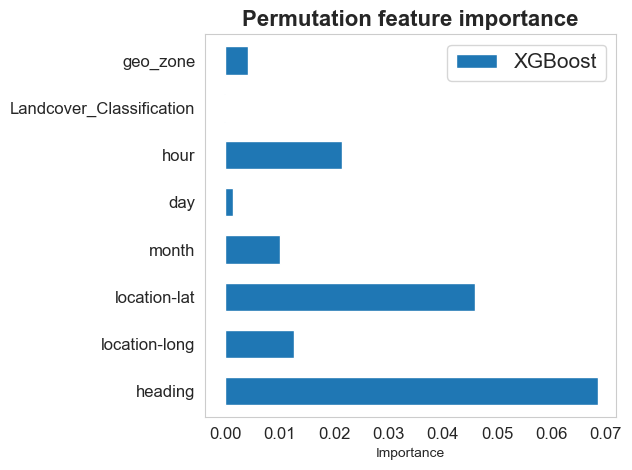

In [22]:
# plot feature importance
plt.figure(figsize=(15, 25))
sns.set_style("whitegrid", {"axes.grid": False})

df_feature_importances.plot.barh(width=0.6)
plt.tick_params(axis="x", which="major", labelsize=12)
plt.tick_params(axis="y", which="major", labelsize=12)
plt.xlabel("Importance")
plt.ylabel("")
plt.legend(fontsize=15, loc="upper right")
plt.title(f"Permutation feature importance", fontweight="bold", fontsize=16)

plt.tight_layout()

The permutation importance provides a broader overview of the feature importances and shows the relative importance of the features on the model. In this case, it is based on the change in the F1 metric score when the feature is randomly permuted and thus destroys the value of the feature. Heading has the highest feature importance, and without it, the models would perform about 0.07 units worse in the F1 score. Location-Lat is in second place with about 0.045, and hour is in third place with about 0.02. The remaining ones are in the range of 0.01 or even lower.

In [23]:
import shap
# data preparation for SHAP
X_test_transformed = best_model.named_steps["pre"].transform(X_test)
X_test_dense = X_test_transformed.toarray()

# extract model of the pipeline
best_model_XGB = results["XGBoost"]["model"].named_steps['model']  # XGBoost model from the pipeline

# fit the explainer
explainer = shap.Explainer(best_model_XGB, X_test_dense)
shap_values = explainer(X_test_dense)


c:\Users\Nutzer\miniforge3\envs\tracking_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 99%|===================| 21066/21255 [00:48<00:00]        


 SHAP-Values for class 0


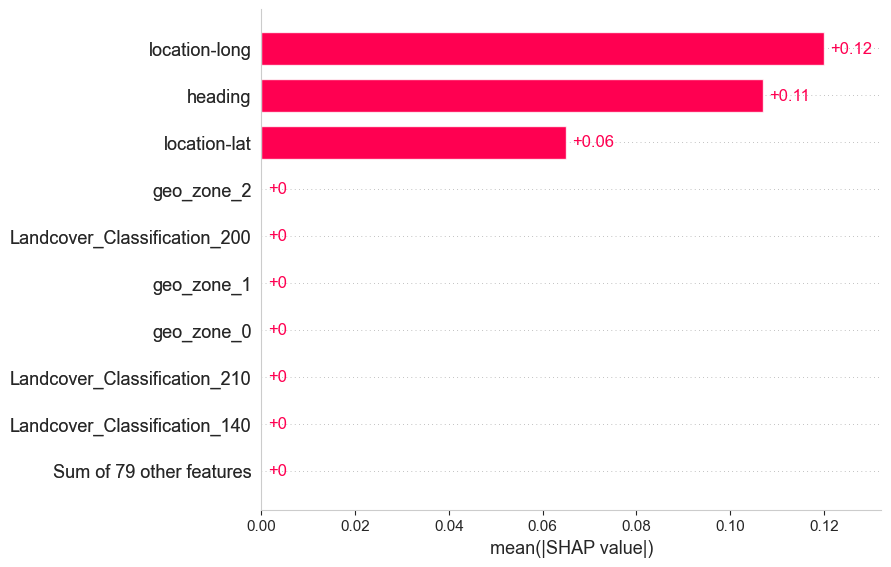


 SHAP-Values for class 1


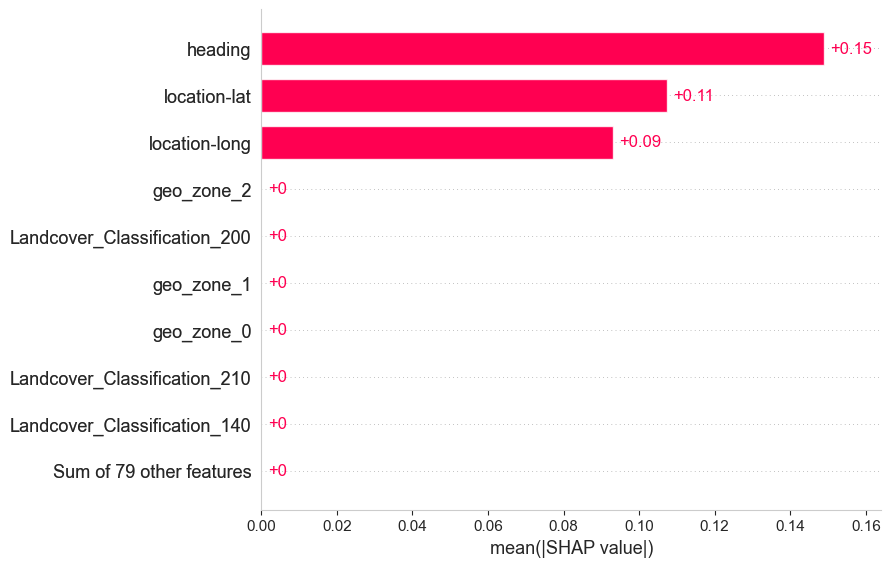


 SHAP-Values for class 2


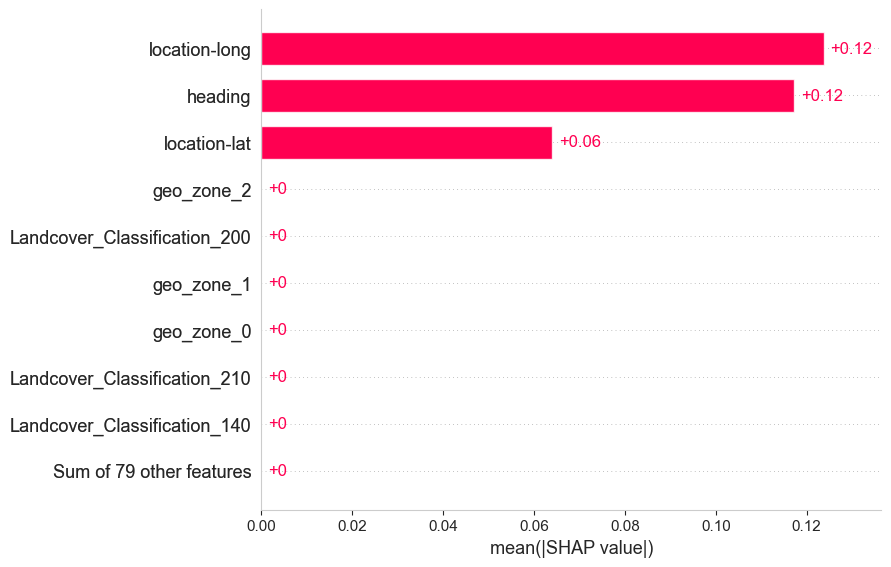

In [24]:
# Data preparation, so the SHAP-plot can show real feature names (better for intepretation)
onehot_features = best_model.named_steps['pre'].named_transformers_['cat'].get_feature_names_out(categorical)
feature_names = numerical + list(onehot_features)
shap_values.feature_names = feature_names

# plot shap for each class
for i, cls in enumerate([0, 1, 2]):
    print(f"\n SHAP-Values for class {cls}")
    shap.plots.bar(shap_values[..., i])


SHAP has the advantage that the feature components can be viewed individually, providing a more detailed overview. However, in this case, only the importance of the three features heading, location, lat(long) long is displayed for each class. Compared to the permutation importances, location long has a much greater impact on model predictions. This is because SHAPE considers correlations differently and considers individual features on the model more isolated. Location long(lat) are strongly correlated, and thus the influence of a feature's permutation importance on the entire model can be smaller because it is masked by the correlated feature.